# Предсказание температуры стали

## Техническое задание 
<ins>*Заказчик:*</ins> ООО «Металлургический комбинат «Так закаляем сталь»;  
<ins>*Цель:*</ins> Оптимизация производственных расходов за счёт уменьшения потребления электроэнергии на этапе обработки стали;  
<ins>*Задачи:*</ins>  Построение модели, которая предскажет температуру стали. Достичь метрики качества МАЕ < 6 (необходимый минимум МАЕ < 8,7).  
<ins>*Исходные данные:*</ins>
- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).  

Данные находятся в папке `/datasets/final_steel/`.

<a id='back-bullet'></a>

## Содержание
**1. Загрузка и анализ данных**
* [Загрузка библиотек](#libraries-bullet)
* [Загрузка данных](#data-bullet)
* [Анализ данных](#analysis-bullet)
* [План решения задачи](#plan-bullet)

**2. Предобработка данных и подготовка признаков**
* [Предобработка данных и подготовка признаков](#rework-bullet)

**3. Построение модели**
* [Линейная регрессия](#lr-bullet)
* [Случайный лес](#rf-bullet)
* [XGBoost](#xg-bullet)
* [CatBoost](#cb-bullet)
* [Результирующая таблица](#st-bullet)

**4. Отчёт о проделанной работе**
* [Отчёт о проделанной работе](#conclusion-bullet)

## 1. Загрузка и анализ данных

### Загрузка библиотек

 <a id='libraries-bullet'></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

### Загрузка данных

<a id='data-bullet'></a>

In [2]:
data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')

### Анализ данных

<a id='analysis-bullet'></a>

In [3]:
#Функция для вывода общей информации о данных:
def data_info(data):
    print('Размер датасета:',data.shape)
    display(data.head())
    tab = pd.concat([data.dtypes, data.isna().mean()*100], axis=1)
    tab.columns=['data_type', 'nan_part, %']
    display(tab.sort_values(by='nan_part, %', ascending=False))
    display(data.describe())

In [4]:
print('Даннные об электродах:')
data_info(data_arc)

Даннные об электродах:
Размер датасета: (14876, 5)


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


,data_type,"nan_part, %"
key,int64,0.0
Начало нагрева дугой,object,0.0
Конец нагрева дугой,object,0.0
Активная мощность,float64,0.0
Реактивная мощность,float64,0.0


,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


В данных о электродов пропусков нет, нужно поменять тип данных у дат. Вопросы вызывают минимальное и максимальное значения реактивной мощности и максимальное значение активной. Определим все строки с отрицательной реактивной мощностью:

In [5]:
data_arc[data_arc['Реактивная мощность'] < 0]['Реактивная мощность'].count()

1

In [6]:
data_arc[data_arc['Реактивная мощность'] < 0]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924


Учитывая, что строка с отрицательным значением только одна, делаем вывод, что перед нами аномалия, которая связана либо с зависанием системы, либо с поломкой датчика определения реактивной мощности. Плавка, в которой присутствует данная строка, исключаем из анализа.  
Далее построим диграммы размаха для активной и реактивной мощностей, а также рассмотрим взаимосвязь между ними:

Text(0.5, 1.0, 'Диаграмма размаха активной мощности')

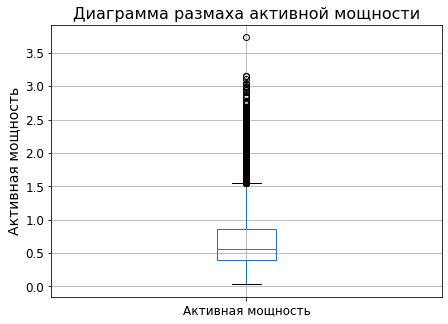

In [7]:
data_arc['Активная мощность'].plot(grid = True, 
                                   style = 'o', 
                                   figsize = (7, 5), 
                                   kind= 'box', 
                                   subplots = True, 
                                   fontsize=12)
plt.ylabel("Активная мощность", fontsize=14)
plt.title('Диаграмма размаха активной мощности', fontsize=16)

Text(0.5, 1.0, 'Диаграмма размаха реактивной мощности')

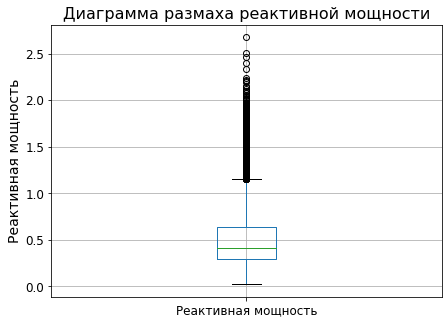

In [8]:
data_arc[data_arc['Реактивная мощность'] >= 0]['Реактивная мощность'].plot(grid = True, 
                                                                           style = 'o', 
                                                                           figsize = (7, 5), 
                                                                           kind= 'box', 
                                                                           subplots = True, 
                                                                           fontsize=12)
plt.ylabel("Реактивная мощность", fontsize=14)
plt.title('Диаграмма размаха реактивной мощности', fontsize=16)

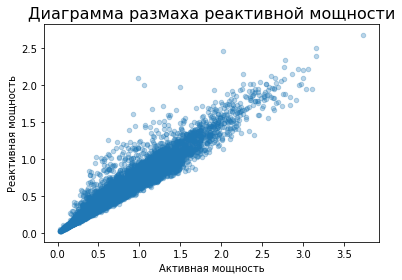

In [9]:
data_arc[data_arc['Реактивная мощность'] >= 0].plot(x='Активная мощность', 
                                                    y='Реактивная мощность', 
                                                    kind='scatter', alpha=0.3)
plt.title('Диаграмма размаха реактивной мощности', fontsize=16)
plt.show()

Данные параметры сильно коррелируют. В дальнейшем следует объеденить их в один параметр **Полная мощность** (https://ru.wikipedia.org/wiki/Электрическая_мощность). Выбросы не критичны и вероятно связаны с различным временем, необходимым для получения нужного хим.состава при использовании разных легирующих элементов в зависимости от технологического процесса (предположение: так как некоторые техпроцессы используются чаще, чем другие, следовательно и выбросы соответствуют тем, что используются реже).Данное предположение проверим на этапе формирования признаков для построения модели.

In [10]:
print('Даннные об объёмах подачи сыпучих материалов:')
data_info(data_bulk)

Даннные об объёмах подачи сыпучих материалов:
Размер датасета: (3129, 16)


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


,data_type,"nan_part, %"
Bulk 8,float64,99.968041
Bulk 13,float64,99.424736
Bulk 9,float64,99.392777
Bulk 2,float64,99.296900
Bulk 7,float64,99.201023
Bulk 5,float64,97.539150
Bulk 10,float64,94.375200
Bulk 11,float64,94.343241
Bulk 1,float64,91.946309
Bulk 6,float64,81.591563


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


Пропуски есть. Пропуски соответствуют тому факту, что сыпучий материал в расплав не добавлялся, можем заменить их нулями. В дальнейшем следует создать параметр **Суммарнный объём сыпучих материалов** и **Количество добавленных материалов**. Типы данных менять не нужно. Для всех сыпучих материалов среднее примерно соответствует медиане, что говорит о нормальном распределении данных.

In [11]:
print('Даннные о времени подачи сыпучих материалов:')
data_info(data_bulk_time)

Даннные о времени подачи сыпучих материалов:
Размер датасета: (3129, 16)


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


,data_type,"nan_part, %"
Bulk 8,object,99.968041
Bulk 13,object,99.424736
Bulk 9,object,99.392777
Bulk 2,object,99.296900
Bulk 7,object,99.201023
Bulk 5,object,97.539150
Bulk 10,object,94.375200
Bulk 11,object,94.343241
Bulk 1,object,91.946309
Bulk 6,object,81.591563


,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


Пропуски есть. Пропуски соответствуют тому факту, что сыпучий материал в расплав не добавлялся, можем заменить их нулями. В дальнейшем следует создать параметр **Суммарнное время подачи сыпучих материалов** и **Количество добавленных материалов**. Типы данных меняем для приведения времени в нужный формат. Для всех сыпучих материалов среднее примерно соответствует медиане, что говорит о нормальном распределении данных. При этом видим высокую корреляцию с данными из прошлого датасета. Возможно, следует исключить данные параметры при построении модели.

In [12]:
print('Даннные о продувке газом материалов:')
data_info(data_gas)

Даннные о продувке газом материалов:
Размер датасета: (3239, 2)


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


,data_type,"nan_part, %"
key,int64,0.0
Газ 1,float64,0.0


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


Пропусков нет, типы данных менять не нужно. Среднее примерно соответствует медиане, что говорит о нормальном распределении данных. Построим диаграмму размаха:

Text(0.5, 1.0, 'Диаграмма размаха продувки газом')

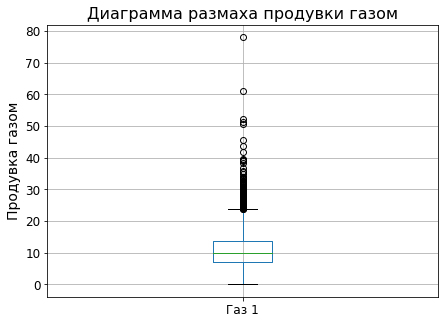

In [13]:
data_gas['Газ 1'].plot(grid = True, 
                       style = 'o',
                       figsize = (7, 5), 
                       kind= 'box', 
                       subplots = True, 
                       fontsize=12)
plt.ylabel("Продувка газом", fontsize=14)
plt.title('Диаграмма размаха продувки газом', fontsize=16)

Вероятно, выбросы связаны с различным кол-вом газа, необходимым для продувки различных видов сыпучих материалов, поэтому не являются критичными.

In [14]:
print('Результаты измерения температуры:')
data_info(data_temp)

Результаты измерения температуры:
Размер датасета: (15907, 3)


,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


,data_type,"nan_part, %"
Температура,float64,18.237254
key,int64,0.000000
Время замера,object,0.000000


,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


Есть пропуски. Для времени необходимо поменять тип данных. Среднее примерно равно медиане, что говорит о нормальном распределении данных. Построим диаграмму размаха:

Text(0.5, 1.0, 'Диаграмма размаха температуры')

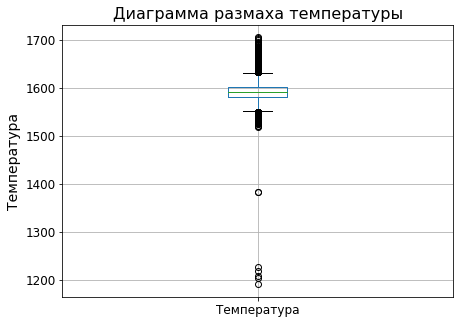

In [15]:
data_temp['Температура'].plot(grid = True, 
                       style = 'o',
                       figsize = (7, 5), 
                       kind= 'box', 
                       subplots = True, 
                       fontsize=12)
plt.ylabel("Температура", fontsize=14)
plt.title('Диаграмма размаха температуры', fontsize=16)

Рассмотрим плавки с температурой меньше 1500С:

In [16]:
keys = data_temp[data_temp['Температура'] < 1500]['key']

In [17]:
temp = []
for i in keys:
    temp.append(data_temp[data_temp['key'] == i])
temp

[      key         Время замера  Температура
 4350  867  2019-06-04 14:21:00       1191.0
 4351  867  2019-06-04 14:29:35       1575.0
 4352  867  2019-06-04 14:30:29       1576.0
 4353  867  2019-06-04 14:43:10       1571.0
 4354  867  2019-06-04 14:52:54       1600.0
 4355  867  2019-06-04 14:57:17       1599.0,
        key         Время замера  Температура
 5978  1214  2019-06-16 05:32:00       1208.0
 5979  1214  2019-06-16 05:49:01       1608.0
 5980  1214  2019-06-16 05:51:28       1608.0
 5981  1214  2019-06-16 05:51:38       1608.0
 5982  1214  2019-06-16 05:52:41       1608.0
 5983  1214  2019-06-16 05:53:03       1608.0
 5984  1214  2019-06-16 05:53:13       1608.0
 5985  1214  2019-06-16 05:54:48       1604.0
 5986  1214  2019-06-16 05:57:21       1604.0
 5987  1214  2019-06-16 06:00:25       1604.0
 5988  1214  2019-06-16 06:06:12       1600.0
 5989  1214  2019-06-16 06:07:28       1596.0
 5990  1214  2019-06-16 06:08:28       1596.0
 5991  1214  2019-06-16 06:09:10       1

Выбросы в районе 1200-1400С соответствуют логике, если печи только запускаются в работу, в следствие чего нужно время на нагрев и расплавку чугуна, из которого после получают сталь. Данный сценарий наблюдается в 4-х случаях из 6-ти примерно с одинаковой периодичностью. Данный вопрос следует уточнить у заказчика, для моделирования данные плавки не подходят. Температура плавления чугуна - 1150С (https://ru.wikipedia.org/wiki/Чугун#:~:text=Температура%20плавления%20чугуна%20—%20от,ниже%2C%20чем%20у%20чистого%20железа). В случае 1818 плавки видим резкий спад температуры в середине процесса, что невозможно и говорит о сбое в работе датчиков измерения, к тому же данные дублированы, следует удалить данную плавку из анализа. Для стали диапазон температур от 1500С до 1750С соответствует норме (https://ru.wikipedia.org/wiki/Сталь#:~:text=Температура%20плавления%3A%201450—1520%20°C.%20Удельная,кДж%2Fкг%20(20%20ккал%2Fкг%2C%2023%20Вт·ч%2Fкг))

Проверим, есть ли взаимосвязь в появлении пропусков:

In [18]:
data_temp[data_temp['Температура'].isna()]

,key,Время замера,Температура
12268,2500,2019-08-06 03:24:43,NaN
12269,2500,2019-08-06 03:25:16,NaN
12270,2500,2019-08-06 03:28:21,NaN
12272,2501,2019-08-06 04:01:59,NaN
12273,2501,2019-08-06 04:14:35,NaN
...,...,...,...
15901,3240,2019-09-01 03:35:16,NaN
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN


Отсутствуют данные для измерения температуры с 2500-й партии. Вероятно, данные находятся на проверке и ещё не загружены в систему, либо произошёл сбой (поломка) в работах датчиков. В любом случае, данные с 2500-й партии для построения модели не подойдут. Учитывая, что температура - целевой признак, но измерений для партии несколько, следует брать за целевое значение последний замер, так как он делается после всех операций тех.процесса получения стали.

In [19]:
print('Данные о проволочных материалах (объём):')
data_info(data_wire)

Данные о проволочных материалах (объём):
Размер датасета: (3081, 10)


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,data_type,"nan_part, %"
Wire 5,float64,99.967543
Wire 7,float64,99.642973
Wire 4,float64,99.545602
Wire 8,float64,99.383317
Wire 9,float64,99.058747
Wire 3,float64,97.955209
Wire 6,float64,97.630639
Wire 2,float64,64.978903
Wire 1,float64,0.843882
key,int64,0.000000


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060484,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


Пропуски есть. Пропуски соответствуют тому факту, что проволочный материал в расплав не добавлялся, можем заменить их нулями. В дальнейшем следует создать параметр **Суммарнный объём проволочных материалов** и **Количество добавленных материалов**. Типы данных менять не нужно. Для всех проволочных материалов среднее примерно соответствует медиане, что говорит о нормальном распределении данных.

In [20]:
print('Данные о проволочных материалах (время):')
data_info(data_wire_time)

Данные о проволочных материалах (время):
Размер датасета: (3081, 10)


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,data_type,"nan_part, %"
Wire 5,object,99.967543
Wire 7,object,99.642973
Wire 4,object,99.545602
Wire 8,object,99.383317
Wire 9,object,99.058747
Wire 3,object,97.955209
Wire 6,object,97.630639
Wire 2,object,64.978903
Wire 1,object,0.843882
key,int64,0.000000


,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


Пропуски есть. Пропуски соответствуют тому факту, что сыпучий материал в расплав не добавлялся, можем заменить их нулями. В дальнейшем следует создать параметр **Суммарнное время подачи проволочных материалов** и **Количество добавленных материалов**. Типы данных меняем для приведения времени в нужный формат. Для всех проволочных материалов среднее примерно соответствует медиане, что говорит о нормальном распределении данных. При этом видим высокую корреляцию с данными из прошлого датасета. Возможно, следует исключить данные параметры при построении модели.

**Вывод:**  
1. Для data_arc найденно аномальное отрицательное значение. Плавка №2116, в которой оно присутствует, необходимо исключить из дальнейшей работы. Плавки с температурой ниже 1500С тоже необходимо исключить до внесения ясности от заказчика. При этом параметры реактивная и активная мощности необходимо объеденить в один - полную мощность. Далее при умножении на время получить признак Работа;
2. Пропуски в датасетах, касающихся материалов (data_bulk.csv, data_bulk_time.csv, data_wire.csv, data_wire_time.csv), соответствуют факту, что материалы в расплав не добавлялись, поэтому их можно заменить нулями. При этом следует создать суммарные параметры и далее исключить из построения модели параметры с сильной корреляцией;
3. Необходимо исключить из анализа данные для 2500-й партии и далее, так как для них отсутствуют значения температуры. При этом за целевой признак необходимо брать последний замер, так как он делается после всех операций тех.процесса получения стали;
4. Вероятно, в большинстве случаев выбросы в данных связаны с разной степенью использования разных технологических процессов; 
4. Необходимо поменять тип данных для времени в датасетах;

<a id='plan-bullet'></a>

## План решения задачи
1. Провести предобработку данных и подготовить признаки: обработать пропуски, изменить типы данных для времени, вывести время работы нагревателя, работу, создать суммарные признаки по материалам, вывести целевой признак, сгруппироать данные по номеру плавки и объединить в один датафрейм, посмотреть на мультиколлинеарность (исключить признаки с высокой корреляцией (> 0.9));
2. Построить модель: построить несколько вариантов моделей, сравнить их, выбрать лучшую. Провести анализ важности признаков у лучшей модели;

[Вернуться к содержанию](#back-bullet)

<a id='rework-bullet'></a>

## 2. Предобработка данных и подготовка признаков

### data_arc.csv

Для удобства переименовываем названия столбцов:

In [21]:
data_arc = data_arc.rename(columns={'Начало нагрева дугой':'time_start',
                         'Конец нагрева дугой':'time_finish',
                         'Активная мощность':'act_power',
                         'Реактивная мощность':'react_power'
                         })

Исключаем плавку №2116 с отрицательным значением реактивной мощности из анализа:

In [22]:
data_arc = data_arc.query('key != 2116')

Меняем тип данных у времени:

In [23]:
data_arc['time_start'] = pd.to_datetime(data_arc['time_start'], format='%Y-%m-%d %H:%M:%S')
data_arc['time_finish'] = pd.to_datetime(data_arc['time_finish'], format='%Y-%m-%d %H:%M:%S')

Вычисляем время работы нагревателя, полную мощность и работу:

In [24]:
data_arc['action_time'] = (data_arc['time_finish'] - data_arc['time_start']).dt.seconds
data_arc['total_power'] = (data_arc['act_power']**2 + data_arc['react_power']**2) ** 0.5
data_arc['work'] = round(data_arc['total_power']*data_arc['action_time'], 2)
new_data_arc = data_arc.drop(['time_start', 
                              'time_finish', 
                              'act_power', 
                              'react_power', 
                              'action_time', 
                              'total_power'], axis = 1)
new_data_arc.head(5)

,key,work
0,1,272.15
1,1,177.42
2,1,154.12
3,1,719.22
4,1,119.47


Выполняем группировку по номеру плавки, вводим признак heat_steps (кол-во нагреваний) и получаем окончательную таблицу с признаками:

In [25]:
data_arc_features = new_data_arc.groupby('key')[['work', 'key']].agg({'work':'sum', 'key':'count'})
data_arc_features.rename(columns={'key':'heat_steps'}, inplace=True)
display(data_arc_features.head())
display(data_arc_features.describe())

,work,heat_steps
key,,
1,1442.38,5
2,881.23,4
3,525.07,5
4,796.92,4
5,1199.13,4


,work,heat_steps
count,3213.000000,3213.000000
mean,893.983358,4.628696
std,642.839145,1.608860
min,15.160000,1.000000
25%,447.320000,4.000000
50%,761.770000,4.000000
75%,1161.470000,6.000000
max,10630.970000,16.000000


### data_bulk.csv

В качестве признаков используем суммарный объём сыпучих материалов в плавке:

In [26]:
new_data_bulk = data_bulk.set_index('key')
new_data_bulk['count_bulk'] = new_data_bulk.count(axis=1)
new_data_bulk
new_data_bulk['sum_bulk'] = new_data_bulk[new_data_bulk.drop('count_bulk', axis=1).columns].sum(axis=1)
data_bulk_features = new_data_bulk[['sum_bulk', 'count_bulk']]
data_bulk_features.head()

,sum_bulk,count_bulk
key,,
1,553.0,4
2,582.0,4
3,544.0,4
4,595.0,4
5,584.0,4


### data_wire.csv

В качестве признаков используем суммарный объём проволочных материалов и кол-во таких материалов в плавке:

In [27]:
new_data_wire = data_wire.set_index('key')
new_data_wire['count_wire'] = new_data_wire.count(axis=1)
new_data_wire
new_data_wire['sum_wire'] = new_data_wire[new_data_wire.drop('count_wire', axis=1).columns].sum(axis=1)
data_wire_features = new_data_wire[['sum_wire', 'count_wire']]
data_wire_features.head()

,sum_wire,count_wire
key,,
1,60.059998,1
2,96.052315,1
3,91.160157,1
4,89.063515,1
5,98.352796,2


👍

### data_gas.csv

Изменяем индексы и переименовываем столбец:

In [28]:
data_gas_features = data_gas.set_index('key').rename(columns={'Газ 1':'gas'})
data_gas_features.head()

,gas
key,
1,29.749986
2,12.555561
3,28.554793
4,18.841219
5,5.413692


👍

### data_temp.csv

Из всех измерений температуры оставляем только первое и последнее. Исключаем все плавки с 2500-й и далее и все плавки с начальной температурой < 1500С:

In [29]:
data_temp_features = (data_temp.groupby('key')['Температура']
                      .agg(['first', 'last']).loc[:2499])
data_temp_features = data_temp_features.rename(columns={'first':'init_temp', 'last':'last_temp'})
data_temp_features = data_temp_features.query('init_temp > 1500') 
data_temp_features.head(5)

,init_temp,last_temp
key,,
1,1571.0,1613.0
2,1581.0,1602.0
3,1596.0,1599.0
4,1601.0,1625.0
5,1576.0,1602.0


In [30]:
data_temp_features.shape

(2473, 2)

### Объединённая таблица признаков

data_bulk_time.csv, data_wire_time.csv в итоговую таблицу не влючаем, так как время подачи материалов для данной задачи значения не имеет

In [31]:
df = (
    data_temp_features
    .join(data_bulk_features)
    .join(data_arc_features)
    .join(data_wire_features)
    .join(data_gas_features)
    )
print(df.shape)
display(df.sample(10))
display(df.describe())

(2473, 9)


,init_temp,last_temp,sum_bulk,count_bulk,work,heat_steps,sum_wire,count_wire,gas
key,,,,,,,,,
266,1567.0,1591.0,586.0,4.0,1250.39,4.0,73.295036,1.0,2.694759
759,1602.0,1620.0,858.0,4.0,1607.57,7.0,101.275200,1.0,12.421341
1506,1572.0,1568.0,404.0,3.0,484.24,5.0,150.399598,2.0,13.430307
2037,1566.0,1589.0,709.0,5.0,969.62,5.0,74.124962,1.0,11.110614
853,1617.0,1601.0,1083.0,5.0,437.19,7.0,176.248794,1.0,18.819971
152,1588.0,1601.0,411.0,3.0,601.63,3.0,96.052315,1.0,5.666654
2244,1593.0,1579.0,715.0,2.0,517.54,3.0,35.075039,1.0,6.989365
1169,1606.0,1599.0,514.0,3.0,146.45,1.0,104.176803,1.0,4.562589
1021,1559.0,1572.0,933.0,5.0,870.69,7.0,141.407760,2.0,31.961845


,init_temp,last_temp,sum_bulk,count_bulk,work,heat_steps,sum_wire,count_wire,gas
count,2473.000000,2473.000000,2404.000000,2404.000000,2470.000000,2470.000000,2369.000000,2369.000000,2471.000000
mean,1589.016175,1595.338051,603.866057,3.545341,904.993146,4.626721,125.248227,1.400169,11.139788
std,24.996127,16.031388,287.210515,1.242214,655.651432,1.609741,64.043741,0.566759,6.328796
min,1519.000000,1541.000000,19.000000,1.000000,15.160000,1.000000,1.918800,1.000000,0.008399
25%,1572.000000,1587.000000,430.000000,3.000000,461.407500,4.000000,88.272080,1.000000,7.102961
50%,1588.000000,1593.000000,604.000000,4.000000,768.745000,4.000000,116.101440,1.000000,9.925930
75%,1605.000000,1599.000000,789.000000,4.000000,1170.257500,6.000000,151.625755,2.000000,13.872453
max,1679.000000,1700.000000,3235.000000,7.000000,10630.970000,16.000000,568.777664,5.000000,77.995040


Количество пропусков в общей таблице:

In [32]:
df.isnull().sum()

init_temp       0
last_temp       0
sum_bulk       69
count_bulk     69
work            3
heat_steps      3
sum_wire      104
count_wire    104
gas             2
dtype: int64

Пропуски по сыпучим и проволочным материалам соответствуют тому факту, что их не добавляли, заменяем нулями. Но есть 3 пропуска по работе. Рассмотрим их:

In [33]:
df[df['work'].isnull()]

,init_temp,last_temp,sum_bulk,count_bulk,work,heat_steps,sum_wire,count_wire,gas
key,,,,,,,,,
195,1583.0,1583.0,NaN,NaN,NaN,NaN,NaN,NaN,0.374436
279,1603.0,1603.0,89.0,1.0,NaN,NaN,99.066236,1.0,7.232359
2116,1579.0,1578.0,335.0,2.0,NaN,NaN,75.216965,1.0,11.582547


In [34]:
df.head(3)

,init_temp,last_temp,sum_bulk,count_bulk,work,heat_steps,sum_wire,count_wire,gas
key,,,,,,,,,
1,1571.0,1613.0,553.0,4.0,1442.38,5.0,60.059998,1.0,29.749986
2,1581.0,1602.0,582.0,4.0,881.23,4.0,96.052315,1.0,12.555561
3,1596.0,1599.0,544.0,4.0,525.07,5.0,91.160157,1.0,28.554793


Выглядит странно, но логике не противоречит, так как температура не росла, соответственно, подогрева не было, поэтому также заменяем пропуски 0 (стоит задать вопрос заказчику, есть ли неподгреваемые плавки?):

In [35]:
df = df.fillna(0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2473 entries, 1 to 2499
Data columns (total 9 columns):
init_temp     2473 non-null float64
last_temp     2473 non-null float64
sum_bulk      2473 non-null float64
count_bulk    2473 non-null float64
work          2473 non-null float64
heat_steps    2473 non-null float64
sum_wire      2473 non-null float64
count_wire    2473 non-null float64
gas           2473 non-null float64
dtypes: float64(9)
memory usage: 273.2 KB


Оценим мультиколлинеарность между получившимися признаками:

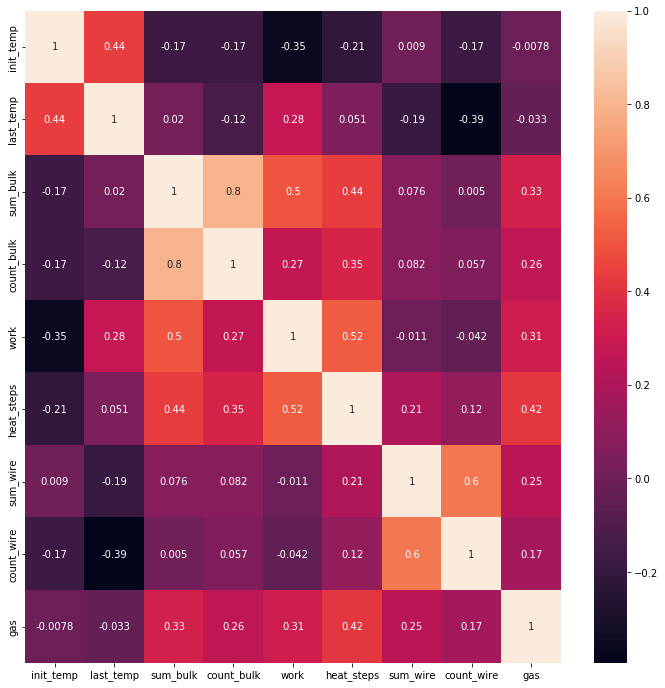

In [36]:
plt.figure(figsize=(12, 12))
sns.heatmap(df.corr(), annot=True)
plt.show()

Видим корреляцию между работой и кол-вом операций нагрева - логично. Кол-во материалов имеет высокую корреляцию с их кол-вом - логично. Кол-во операций нагрева коррелирует с объёмом матриалов и их кол-вом, что логично - больше материалов = больше времени греть, чтобы получить нужный хим.состав. Данные готовы для построения моделей.

[Вернуться к содержанию](#back-bullet)

## 3. Построение модели

Выделяем признаки и целевой признак, делим данные на выборки:

In [37]:
target = df['last_temp']
features = df.drop('last_temp', axis=1)
features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                            target, 
                                                                            test_size = 0.25, 
                                                                            random_state = 12345)

Приступим к построению моделей. Для работы выбраны следующие модели: линейная регрессия, случайный лес, XGBoost, CatBoost

<a id='lr-bullet'></a>

### Линейная регрессия

In [38]:
model = LinearRegression()
model.fit(features_train, target_train)
result = model.predict(features_test)
linreg_score = mean_absolute_error(target_test, result)
print('Test MAE=', linreg_score)

Test MAE= 7.843746993169324


Значение МАЕ соответствует необходимому минимуму. Перейдём к следующей модели:

[Вернуться к содержанию](#back-bullet)

<a id='rf-bullet'></a>

### Случайный лес

In [ ]:
#диапазон параметров уменьшен по результатам предыдущего моделирования с целью сокращения времени моделирования
model = RandomForestRegressor()
params = {
    'n_estimators':[x for x in range(490, 491, 1)],
    'max_depth':[x for x in range(188, 189, 1)], 
    'min_samples_leaf':[x for x in range(1, 2, 1)],
    'min_samples_split':[x for x in range(14, 15, 1)],
}
grid = RandomizedSearchCV(model, 
                          params,  
                          n_iter = 10, 
                          random_state = 12345, 
                          cv = 5)
grid.fit(features_train, target_train)
result = grid.predict(features_test)
forest_score = mean_absolute_error(target_test, result)
print('Лучшие параметры:', grid.best_params_)
print('Test MAE=', forest_score)

Результат уже значительно лучше.

[Вернуться к содержанию](#back-bullet)

 Перейдём к моделям градиентного бустинга:

<a id='xg-bullet'></a>

### XGBoost

In [ ]:
model = XGBRegressor(
    n_estimators = 1500,
    learning_rate = 0.008,
    reg_alpha = 15,
    objective = 'reg:squarederror',
    random_state = 12345
)
model.fit(features_train, target_train)

result = model.predict(features_test)
xgb_score = mean_absolute_error(target_test, result)
print('Test MAE=', xgb_score)

Максимально близко приблизились к требуемому значению МАЕ = 6.

[Вернуться к содержанию](#back-bullet)

<a id='cb-bullet'></a>

### CatBoost

In [ ]:
model = CatBoostRegressor(
    loss_function='MAE', 
    random_state = 12345, 
    iterations = 1500, 
    learning_rate = 0.008, 
    l2_leaf_reg = 50,
    )
model.fit(features_train, target_train, verbose = 100)

result = model.predict(features_test)
cb_score = mean_absolute_error(target_test, result)
print('\nTest MAE =', cb_score)

Поставленная задача выполнена. МАЕ < 6.

[Вернуться к содержанию](#back-bullet)

Сделаем проверку по фиктивному среднему:

### Фиктивное предсказание по среднему

In [39]:
dummy_pred = pd.Series(target_train.mean(), index=target_test.index)
dummy_result = mean_absolute_error(target_test, dummy_pred)
print('Dummy MAE =', dummy_result)

Dummy MAE = 9.746945433442612


<a id='st-bullet'></a>

### Результирующая таблица

In [ ]:
(
    pd.Series(
    data=[linreg_score, forest_score, xgb_score, cb_score, dummy_result],
    index=['LinearRegression', 'RandomForest', 'XGBoost', 'CatBoost', 'Dummy_mean'],
    name='MAE_score'
    )
    .sort_values()
    .to_frame()
)

Наилучший результат показала модель CatBoost с МАЕ = 5.98

Рассмотрим важность признаков в лучшей модели:

In [ ]:
def validate_the_importance(model):
    feature_importance = pd.Series(model.feature_importances_, index = features_test.columns).sort_values(ascending=False)

    ax = sns.barplot(x = feature_importance, y = feature_importance.index)
    _ = ax.set(xlabel='Уровень важности признаков', ylabel = 'Признаки')
    _ = ax.set_title('Визуализация важности признаков')

validate_the_importance(model)

Наибольшее влияние на конечную температу оказывает начальная температура - чем больше разница, тем больше нужно нагревать.2-й признак по важности - работа: чем она больше, тем больше энергии идёт на нагрев - логично.  Далее следует кол-во проволочных материалов. Видим, что использовать проволоку гораздо энергозатратнее, чем сыпучие материалы. 
В целях оптимизации расходов заказчику следует обратить внимание на начальную температуру расплава и найти альтернативу материалам в виде проволоки,если это возможно.

[Вернуться к содержанию](#back-bullet)

<a id='conclusion-bullet'></a>

## 4. Отчёт о проделанной работе

* В процессе работы над проектом были в полном объёме выполнены все пункты плана: проведена предобработка данных и подготовлена таблица с признаками, построены 4 модели для прогнозирования температуры, выбрана лучшая модель, выполняющая поставленную задачу, для которой проведён анализ важности признаков;  

* В процессе работы над проектом возникали только вопросы, касающиеся предметной области - металлургии -, ответы на которые были получены в процессе взаимодействия с коллегами и специалистами-металлургами;

* Из 4 построенных моделей в процессе сравнения наилучший результат показала модель градиентного бустинга CatBoost с МАЕ = 5.98.

* В результате анализа важности признаков модели полученны следующие результаты: наибольшее влияние оказывают следующие факторы - начальная температура, кол-во затраченной работы и объём использованных проволочных материалов. Согласно имеющимся данным, рекомендую обратить внимание на уменьшение диапазона разброса начальной температуры, проанализировать оборудование на факт наличия утечек энергиии, ввести автомотическую фиксацию аномалий и всех сопутствующих производственных факторов для анализа с целью уменьшения будущих расходов.

[Вернуться к содержанию](#back-bullet)